In [1]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import glob
import random

# Load dataset

In [2]:
# Define files
# filenames = glob.glob("100_sites_training_data/*train.npy")
# filenames = glob.glob("400_sites_training_data/*train.npy")
filenames = glob.glob("*training_data/*train.npy")

# Randomly shuffle file order
# random.shuffle(filenames)

# Concatenate files into array
train = np.array([np.load(fname) for fname in filenames])
train = train.reshape(train.shape[1]*train.shape[0], train.shape[2])
print(train.shape)

# # Get every nth sample
# train = train[::10, :] # Every 10th is reasonable 
np.random.shuffle(train)
print(train.shape)

(12799236, 7)
(12799236, 7)


In [3]:
Y = train[:, 0]
X = train[:, 1:]
feature_inds = [0, 1, 2, 3, 4, 5] # Mean temperature, 0 - 365 day mean temperature, mean precip, 0 - 90 day mean precip, 0 - 365 mean day precip. 


X = X[:, feature_inds] # Ignore time
print(Y.shape)
print(X.shape)

(12799236,)
(12799236, 6)


In [4]:
# Define training and test inds
n_train = int(Y.shape[0] * 0.8) # 80 % training
training_inds = np.arange(0, n_train)
testing_inds = np.arange(n_train, len(Y))
n_test = len(testing_inds)

print(n_train)
print(n_test)

10239388
2559848


# Define training and testing data sets

In [5]:
# Train
X_train = X[training_inds, :]
Y_train = Y[training_inds]

# Test
X_test = X[testing_inds, :]

# Train model

In [6]:
%%time
rf_model = RandomForestRegressor(n_jobs=64, n_estimators=64)
rf_model.fit(X_train, Y_train)

CPU times: user 2h 5min 11s, sys: 16.9 s, total: 2h 5min 28s
Wall time: 2min 15s


RandomForestRegressor(n_estimators=64, n_jobs=64)

# Save model

In [7]:
# # The sklearn model is held internally in the esem model
# with open("rf_model.pkl","wb") as f:
#     pickle.dump(rf_model, f)

# Inference

In [8]:
%%time
Y_rf_test = rf_model.predict(X_test)

CPU times: user 3min 55s, sys: 1min 2s, total: 4min 57s
Wall time: 6.98 s


# Perform analysis

In [9]:
x_1_to_1 = np.array([-9999, 9999])
y_1_to_1 = np.array([-9999, 9999])

In [10]:
def calc_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calc_bias(predictions, targets):
    return (predictions - targets).mean()

Text(0.5, 1.0, 'Slope = 0.9516861381021907\nR^2 = 0.9706889109516057,\np = 0.0,\nRMSE = 1.8938594088105027,\nBias = 0.0030660099905804187,\nN = 2559848,\nX-axis Mean Magnitude = 6.646508528612089')

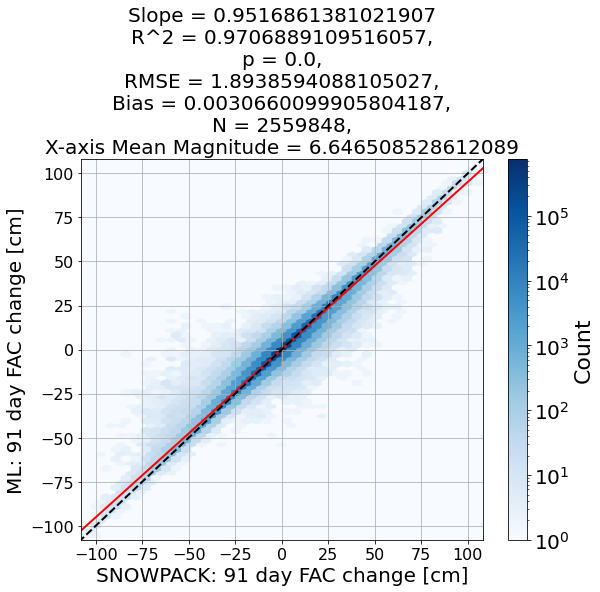

In [11]:
# Random Forest 
x = Y[testing_inds] * 100 # Truth (cm)
y = Y_rf_test * 100 # Prediction (cm)
lin_reg = stats.linregress(x, y)
rmse = calc_rmse(y, x)
bias = calc_bias(y, x)

# Limit
lim = np.max([np.abs(x).max(), np.abs(y).max()])

plt.figure(figsize=(9, 7))
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])
plt.hexbin(x, y, extent=(-lim, lim, -lim, lim), cmap=plt.cm.Blues, bins='log', gridsize=(40, 40))
cb = plt.colorbar()
cb.set_label("Count", fontsize=22)
cb.ax.tick_params(labelsize=20) 
plt.plot(x_1_to_1, lin_reg.intercept + lin_reg.slope*x_1_to_1, 'r', label='fitted line', linewidth=2)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.grid()
plt.xlabel("SNOWPACK: 91 day FAC change [cm]", fontsize=20)
plt.ylabel("ML: 91 day FAC change [cm]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Slope = " + str(lin_reg.slope) + \
          "\nR^2 = " + str(lin_reg.rvalue**2) + \
          ",\np = " + str(lin_reg.pvalue) + \
          ",\nRMSE = " + str(rmse) + \
          ",\nBias = " + str(bias) + \
          ",\nN = " + str(n_test) + \
          ",\nX-axis Mean Magnitude = " + str(np.abs(x).mean()),
         fontsize=20)

80.76274223081035


(array([      0.,  250000.,  500000.,  750000., 1000000., 1250000.,
        1500000., 1750000., 2000000., 2250000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

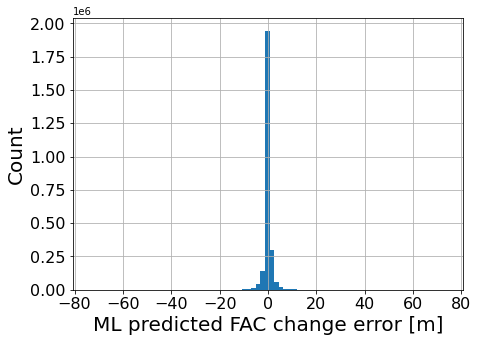

In [12]:
diff = y - x
limit = np.abs(diff).max()
print(limit)

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(diff, bins=75)
plt.grid()
plt.xlim([-limit, limit])
plt.xlabel("ML predicted FAC change error [m]", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Paper figure

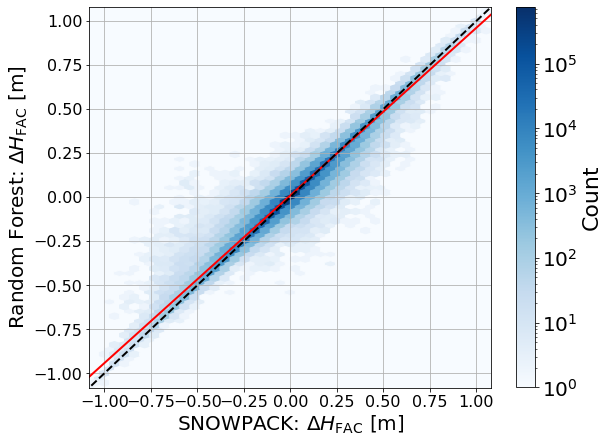

In [13]:
lim = lim / 100
x = x / 100
y = y / 100

plt.figure(figsize=(9, 7))
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])
plt.hexbin(x, y, extent=(-lim, lim, -lim, lim), cmap=plt.cm.Blues, bins='log', gridsize=(40, 40))
cb = plt.colorbar()
cb.set_label("Count", fontsize=22)
cb.ax.tick_params(labelsize=20) 
plt.plot(x_1_to_1, lin_reg.intercept + lin_reg.slope*x_1_to_1, 'r', label='fitted line', linewidth=2)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.grid()
plt.xlabel("SNOWPACK: $\Delta H_{\mathrm{FAC}}$ [m]", fontsize=20)
plt.ylabel("Random Forest: $\Delta H_{\mathrm{FAC}}$ [m]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("figures/model_eval_scatter.pdf", dpi=50)

In [15]:
# Facts for paper

# Percentage of SNOWPACK samples with magnitude greater than 25 cm
percent = 100 * (n_test - np.count_nonzero(x > 0.25)) / n_test
print(percent)

97.27499445279564
